


# Importing & Installing Libraries

In [3]:
#installing required library
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.2 MB/s 


In [217]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import sweetviz
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, roc_auc_score
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor


# I. Preparing Data

##Importing the data

In [117]:
def wrangle(filepath):
    #read csv file into df
    df = pd.read_csv(filepath)

    #to subset properties in capital fed
    mask_flat = df["type_of_building"] == "Flat"
    
    
    #remove outliers by surface area 
    low,high =df["area"].quantile([0.1,0.9])
    mask_area = df["area"].between(low,high)

    #drop columns wiith null values greater than 50 %
    for column in df:
        if round(df[column].isnull().sum() / len(df),1) >= 0.5:
            df.drop(columns=[column], inplace=True)
    
    
    #drop leaky colums
    df.drop(columns=['Price_sqft'],inplace=True)

    #drop low and high cardinality categorical variables
    df.drop(columns=["Unnamed: 0", "type_of_building", "Address", "desc", "Bathrooms","Status", "neworold"], inplace=True)

    #drop duplicate rows
    df.drop_duplicates(keep=False, inplace=True)

    df = df[mask_flat & mask_area]

    
    return df

##EDA

In [83]:
df.isnull().sum() / len(df)

price        0.000000
area         0.000000
latitude     0.000000
longitude    0.000000
Bathrooms    0.000000
Balcony      0.335586
Status       0.076372
neworold     0.000000
dtype: float64

In [118]:
df = wrangle("drive/MyDrive/delhi housing/Delhi_v2.csv")
print("df shape:", df.shape)
df.head()

df shape: (4853, 6)


<ipython-input-117-c5c5c95bebc1>:28: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,price,area,latitude,longitude,Bedrooms,Balcony
0,5600000.0,1350.0,28.608850,77.460560,3.0,NaN
1,8800000.0,1490.0,28.374236,76.952416,3.0,NaN
3,3810000.0,1050.0,28.566914,77.436434,2.0,3.0
4,6200000.0,1350.0,28.520732,77.356491,2.0,3.0
6,3270000.0,890.0,28.610645,77.455837,2.0,3.0


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4853 entries, 0 to 7737
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      4853 non-null   float64
 1   area       4853 non-null   float64
 2   latitude   4853 non-null   float64
 3   longitude  4853 non-null   float64
 4   Bedrooms   4853 non-null   float64
 5   Balcony    3219 non-null   float64
dtypes: float64(6)
memory usage: 265.4 KB


                                             |          | [  0%]   00:00 -> (? left)


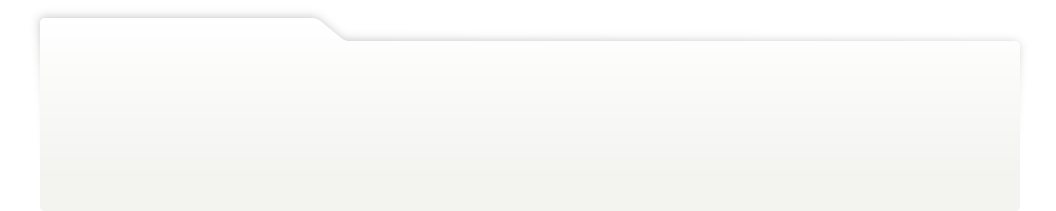
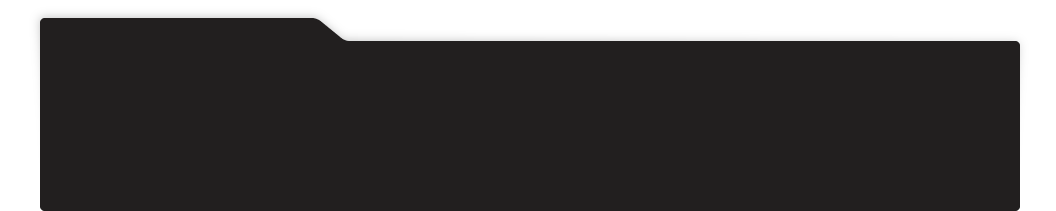
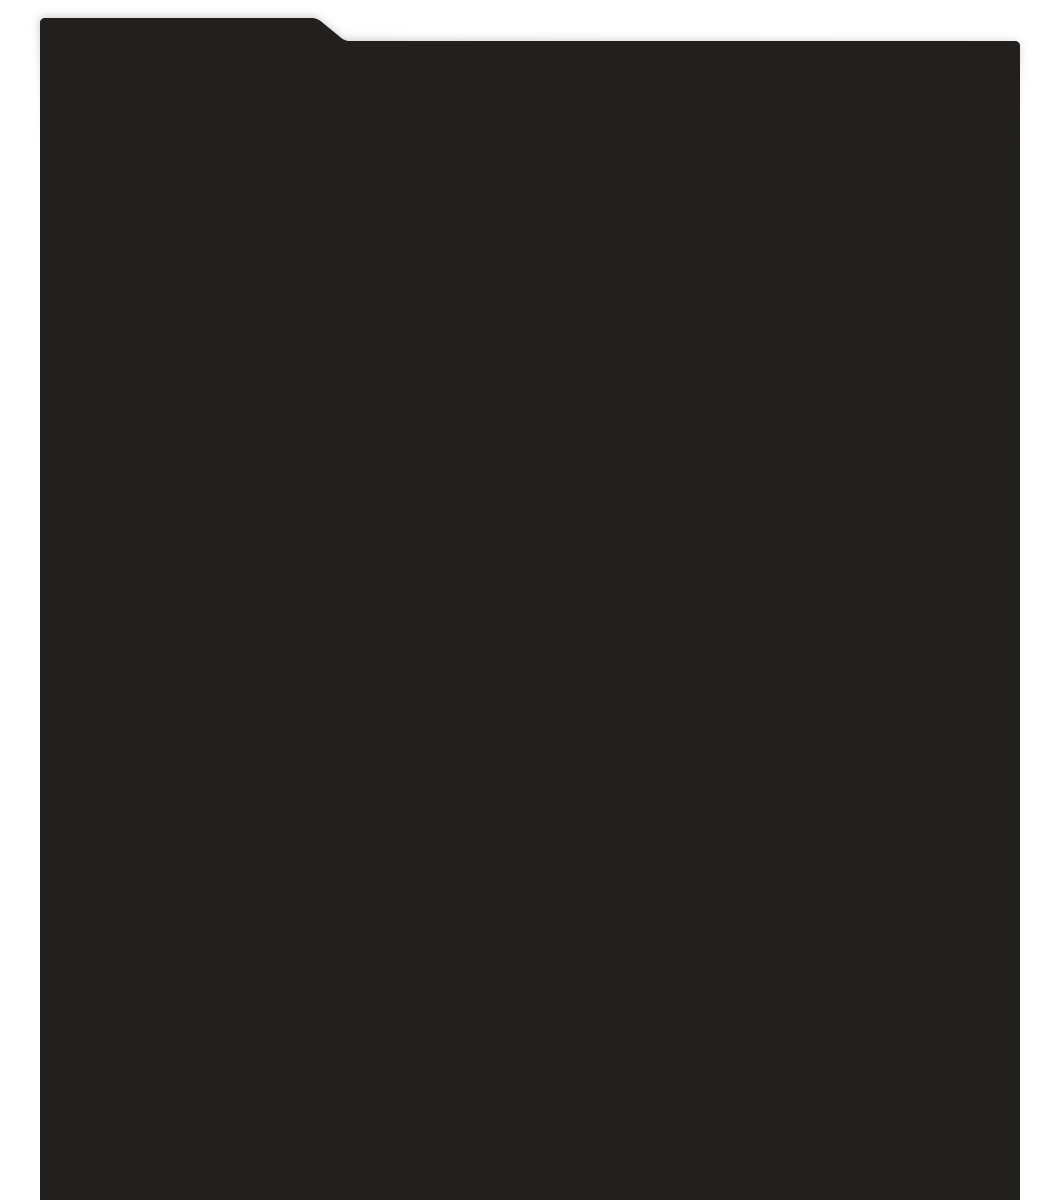
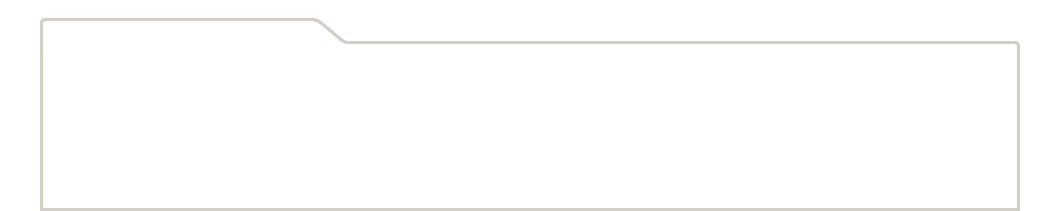
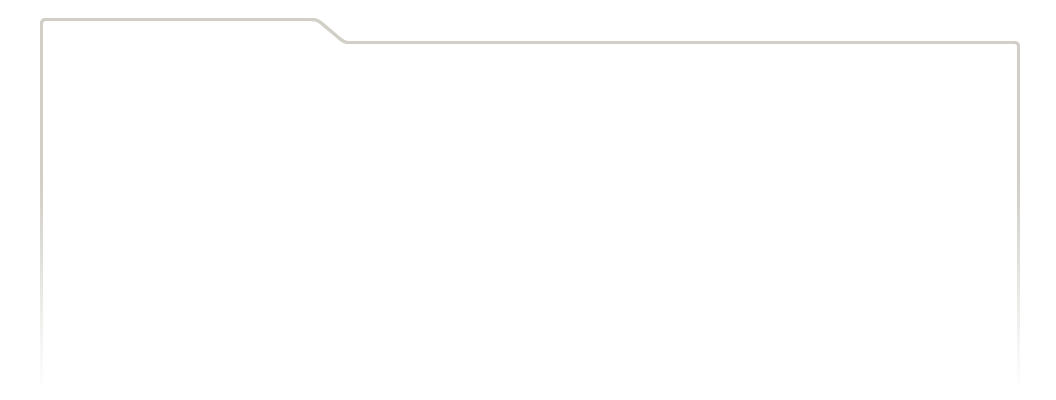
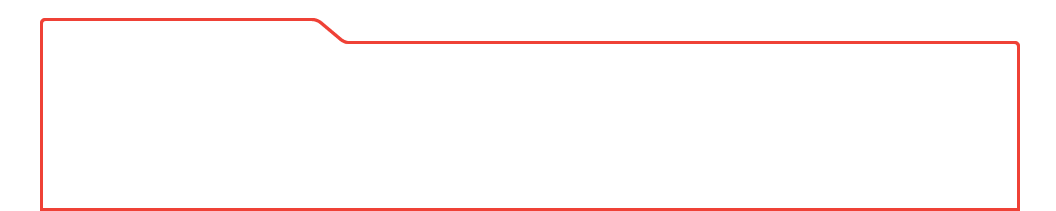
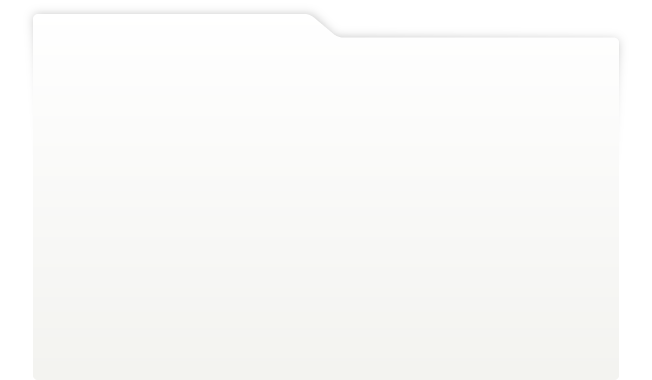
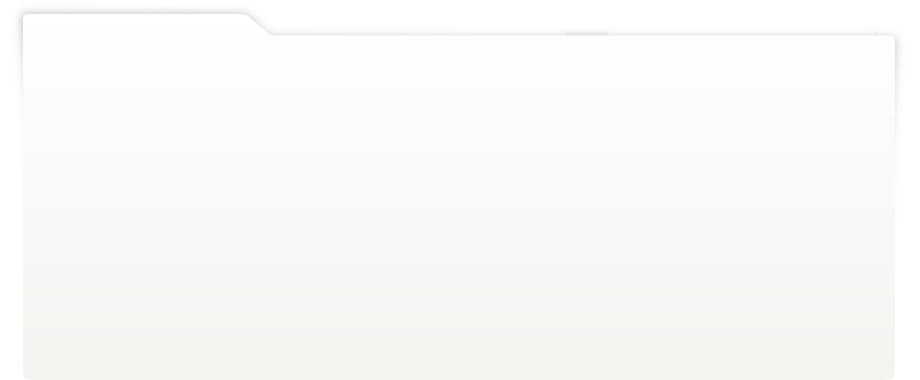
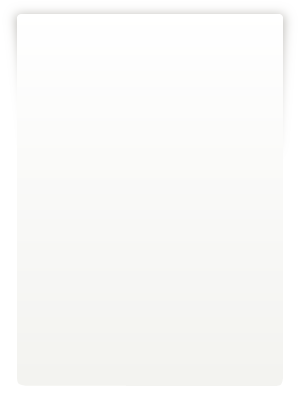
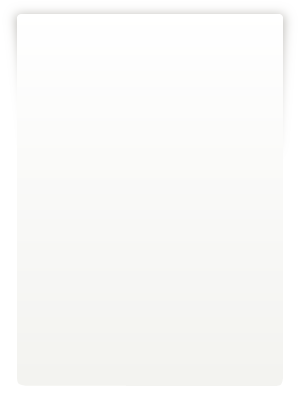
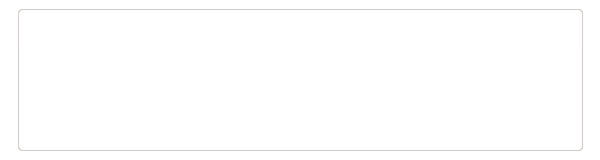
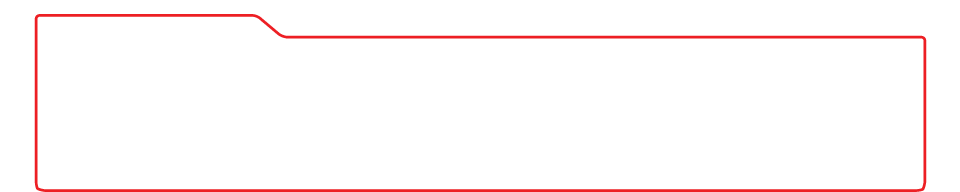
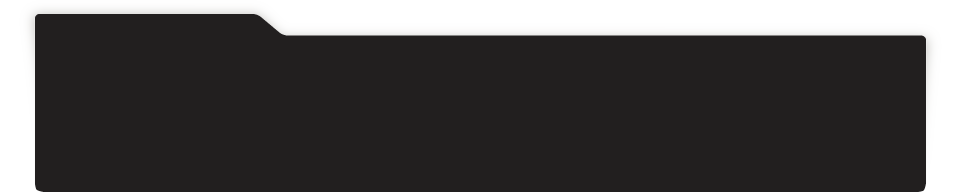
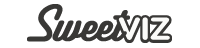
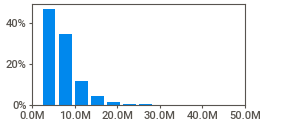
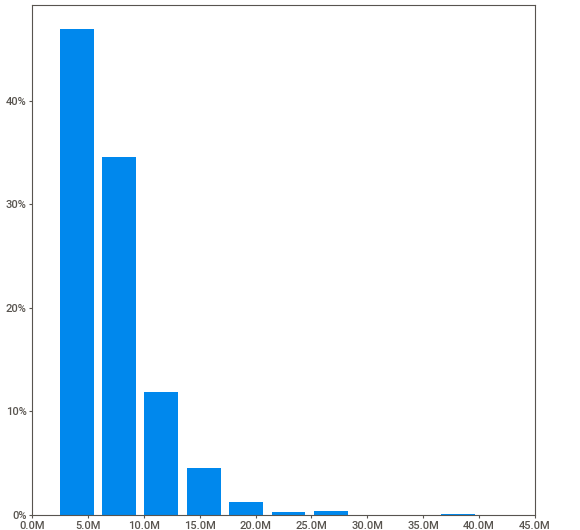
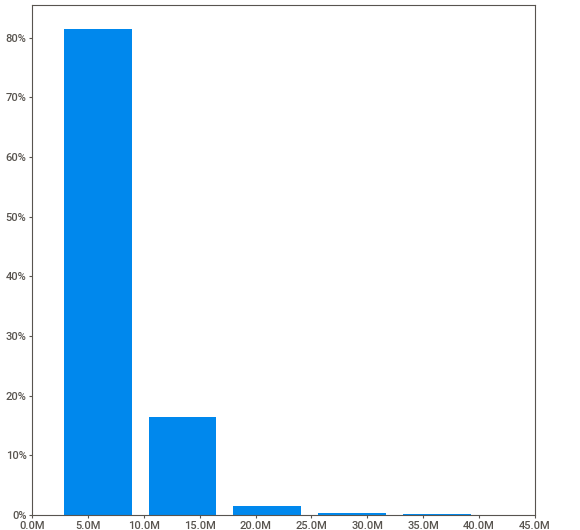
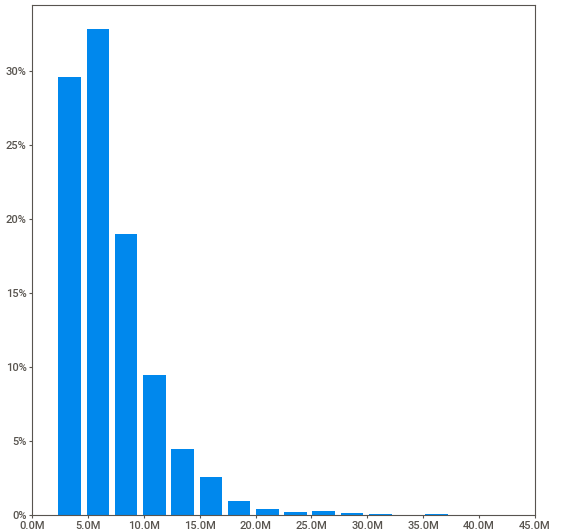
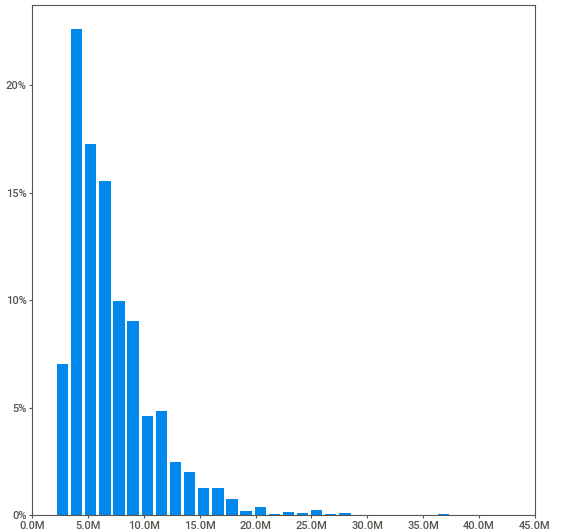
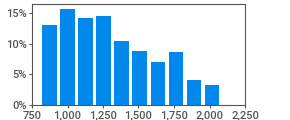
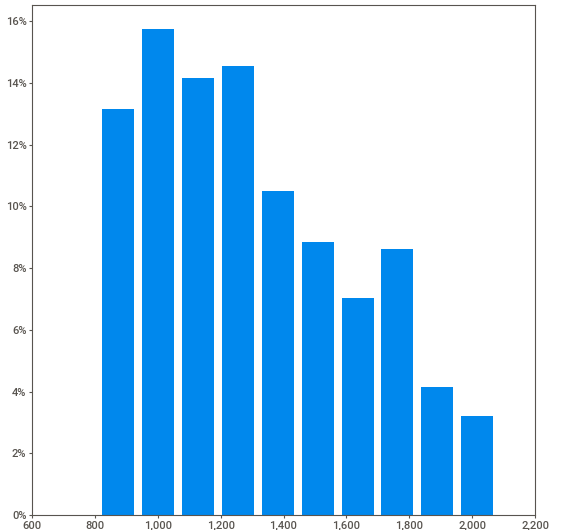
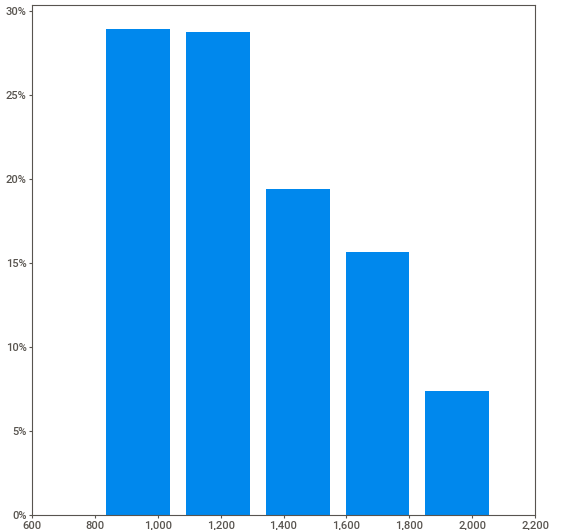
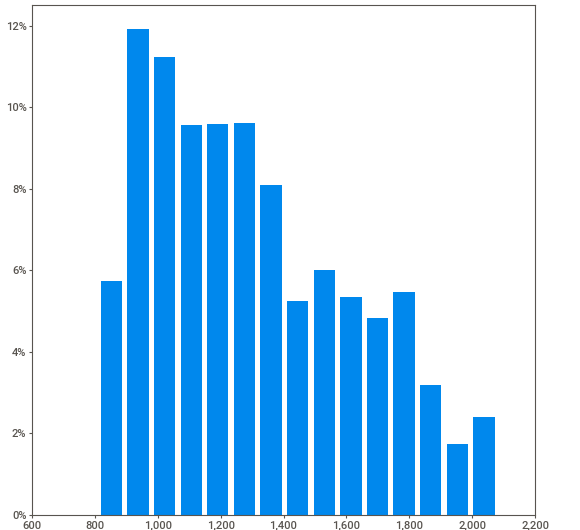
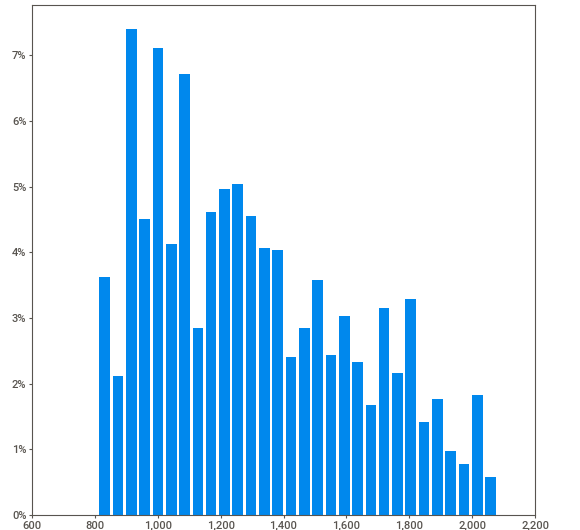
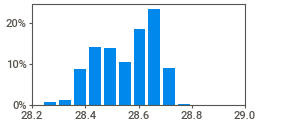
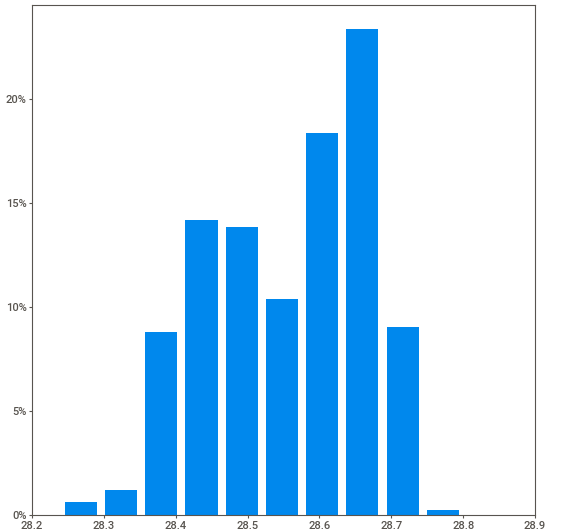
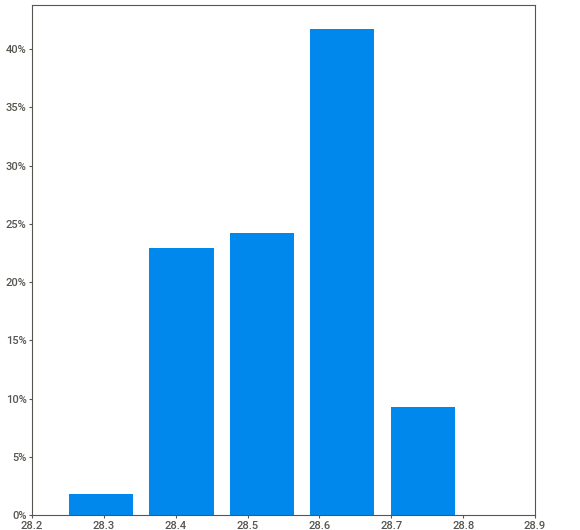
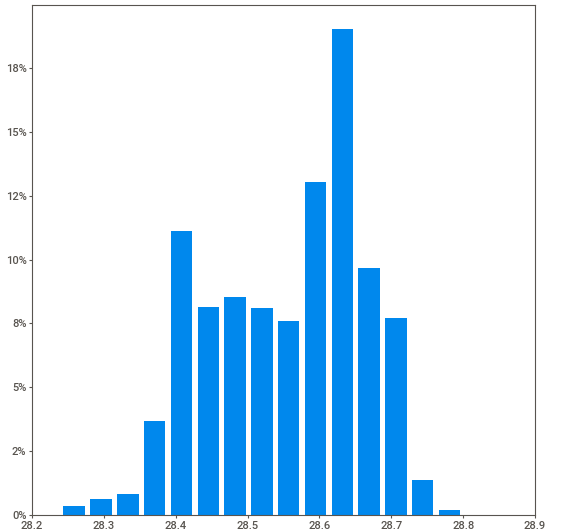
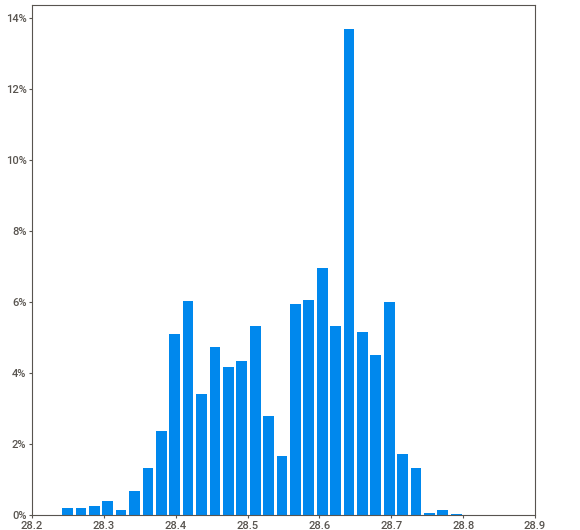
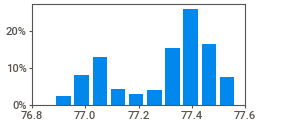
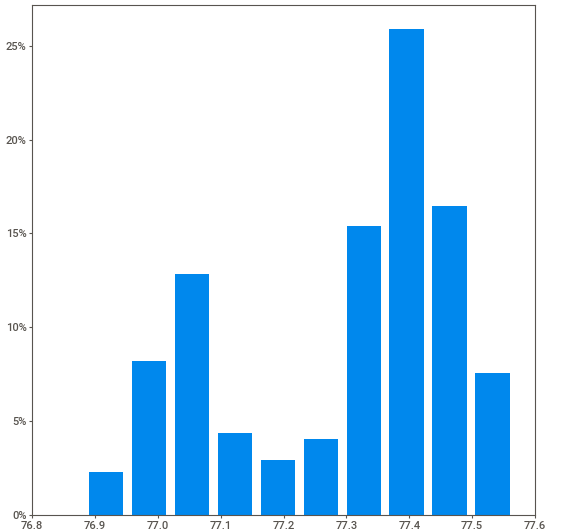
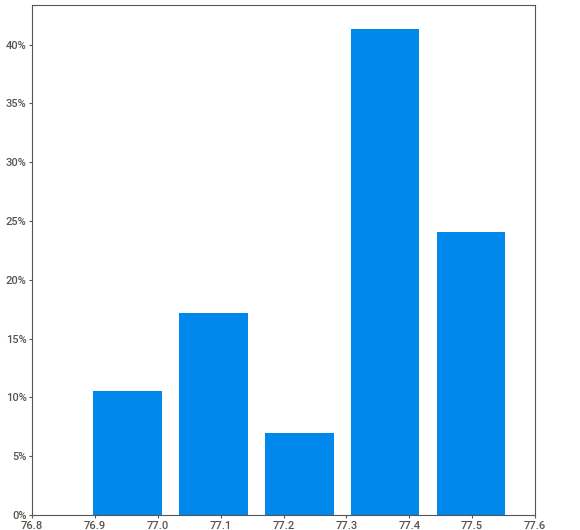
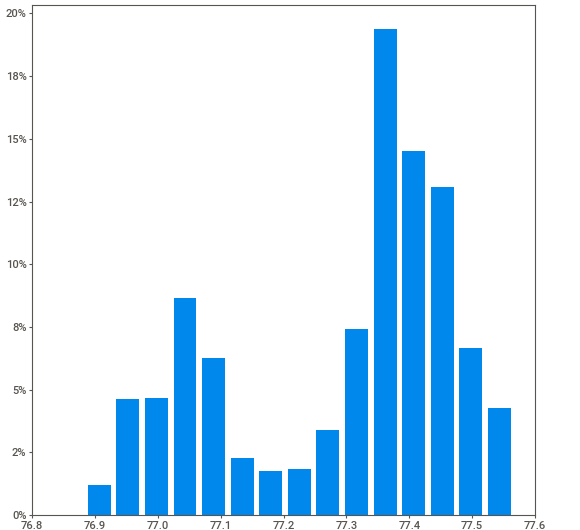
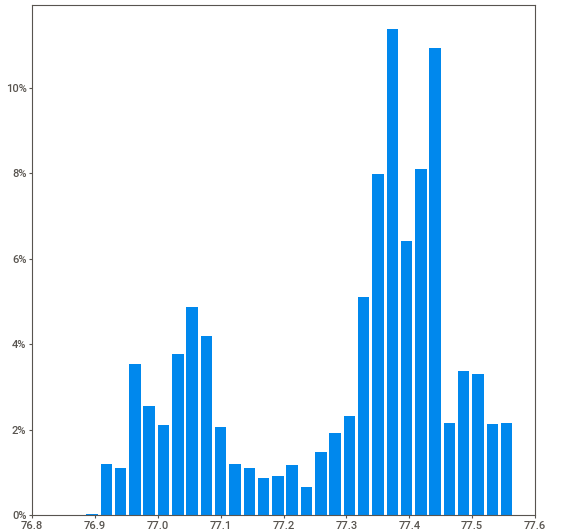
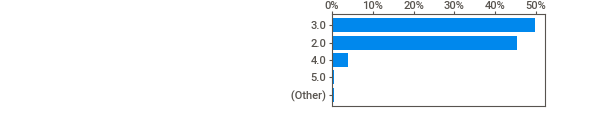
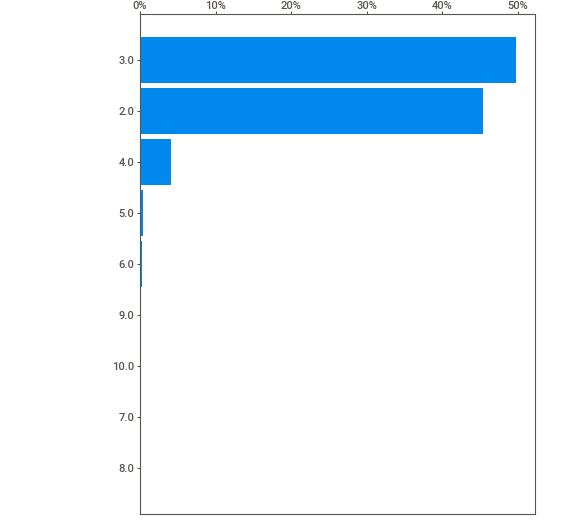
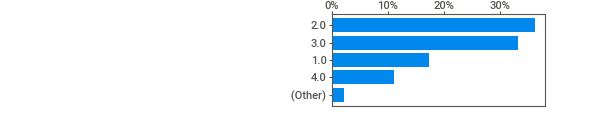
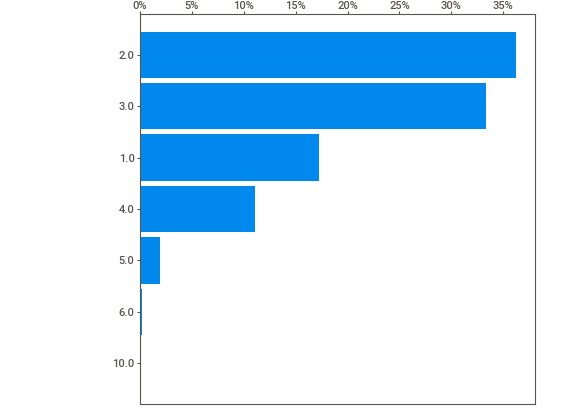
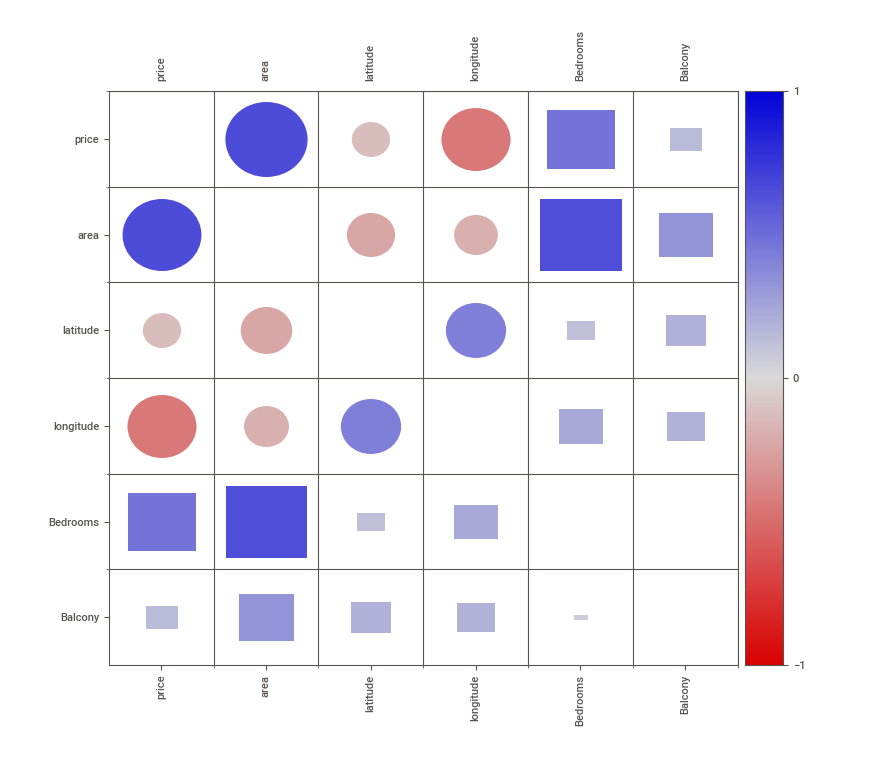
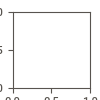

In [193]:
#autoEDA using sweetviz
autoEDA = sweetviz.analyze(df)
autoEDA.show_notebook()

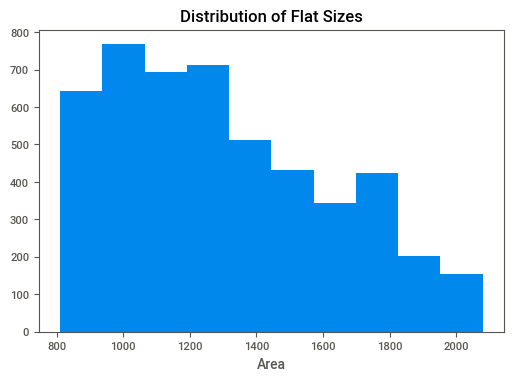

In [85]:
plt.hist(df["area"])
plt.xlabel("Area")
plt.title("Distribution of Flat Sizes");

Text(0.5, 1.0, 'Delhi')

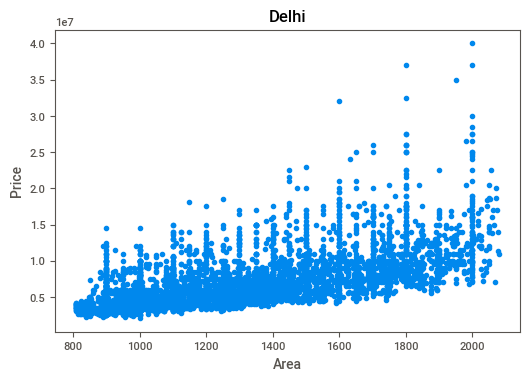

In [86]:
# Build scatter plot
plt.scatter(x=df["area"], y = df["price"])


# Label axes
plt.xlabel("Area")
plt.ylabel("Price")

# Add title
plt.title("Delhi")

In [12]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="latitude",
    y="longitude",
    z="price",
    labels={"longitude": "longitude", "latitude": "latitude", "price": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

In [13]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat = "latitude",
    lon ="longitude",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price",
    hover_data=["price"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")



fig.show()

In [14]:
df.describe()["area"]

count    4878.000000
mean     1300.579131
std       321.753664
min       810.000000
25%      1025.000000
50%      1250.000000
75%      1535.750000
max      2080.000000
Name: area, dtype: float64

In [15]:
df.nunique()

price                433
area                 647
latitude            2069
longitude           2051
Bathrooms              8
Balcony                7
Furnished_status       3
dtype: int64

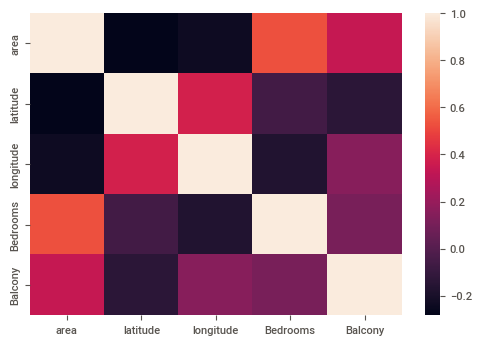

In [119]:
corr = df.select_dtypes("number").drop(columns="price").corr()
sns.heatmap(corr)

In [104]:
corr

,area,latitude,longitude,Bedrooms,Balcony
area,1.000000,-0.283782,-0.239396,0.534409,0.341001
latitude,-0.283782,1.000000,0.385524,-0.059467,-0.132117
longitude,-0.239396,0.385524,1.000000,-0.168613,0.155077
Bedrooms,0.534409,-0.059467,-0.168613,1.000000,0.110124
Balcony,0.341001,-0.132117,0.155077,0.110124,1.000000


In [18]:
df[["Bathrooms","price"]].corr()

,Bathrooms,price
Bathrooms,1.000000,0.448149
price,0.448149,1.000000


In [100]:
df[["area","price"]].corr()

,area,price
area,1.00000,0.63777
price,0.63777,1.00000


In [20]:
#checking for null values
display(df.isna().sum()) #no null values

price                  0
area                   0
latitude               0
longitude              0
Bathrooms              0
Balcony             1646
Furnished_status    2430
dtype: int64

##Split the Data

In [120]:
target = "price"
X = df.drop(columns = target)
y = df[target]

In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42 
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3882, 5)
y_train shape: (3882,)
X_test shape: (971, 5)
y_test shape: (971,)


In [144]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3882 entries, 7669 to 1335
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area       3882 non-null   float64
 1   latitude   3882 non-null   float64
 2   longitude  3882 non-null   float64
 3   Bedrooms   3882 non-null   float64
 4   Balcony    2567 non-null   float64
dtypes: float64(5)
memory usage: 182.0 KB


### Scaling the data

In [132]:
X1 = X
y1 = y

In [133]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, test_size = 0.2, random_state = 42 
)

In [134]:
#defining scaling object
scaler = StandardScaler()

In [135]:
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

# II. MODELS

In [162]:
r2_scores_train = {}
r2_scores_test = {}

## Baseline

In [158]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean flat price:", round(y_mean,2))

print("Baseline MAE:", round(mean_absolute_error(y_train, y_pred_baseline), 2))

Mean flat price: 7107189.59
Baseline MAE: 2802138.1


In [222]:
r2_scores_train.update({"Baseline": r2_score(y_train, y_pred_baseline)})
r2_scores_test.update({"Baseline": r2_score(y_test, [y_mean] * len(y_test))})

## Linear Regression

In [172]:
model_linear = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

In [173]:
model_linear.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [176]:
y_pred_training_linear = model_linear.predict(X_train)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training_linear))

Training MAE: 1692160.885040594


In [175]:
y_pred_test_linear = pd.Series(model_linear.predict(X_test))
print("Testing MAE:", mean_absolute_error(y_test, y_pred_test_linear))

Testing MAE: 1662812.1758427075


In [223]:
r2_scores_train.update({"Linear": r2_score(y_train, y_pred_training_linear)})
r2_scores_test.update({"Linear": r2_score(y_test, y_pred_test_linear)})

## Ridge

In [154]:
model_ridge = make_pipeline(
    SimpleImputer(),
    Ridge(alpha=0.7)
)
model_ridge.fit(X_train, y_train)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('ridge', Ridge(alpha=0.7))])

### on unscaled data

In [155]:
y_pred_training = model_ridge.predict(X_train)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 1690788.3857997374


In [156]:
y_pred_test = pd.Series(model_ridge.predict(X_test))

In [157]:
y_pred_test.head()

0    2.572631e+06
1    6.474933e+06
2    6.313260e+06
3    4.542963e+06
4    8.875884e+06
dtype: float64

In [128]:
print("Testing MAE:", mean_absolute_error(y_test, y_pred_test))

Testing MAE: 1661285.028719826


In [129]:
r2_score(y_test, y_pred_test)

0.5604504873951196

In [130]:
r2_score(y_train, y_pred_training)

0.5477736348985303

In [163]:
r2_scores_train.update({"Ridge": r2_score(y_train, y_pred_training)})
r2_scores_test.update({"Ridge": r2_score(y_test, y_pred_test) })

### on scaled data

In [166]:
model_ridge.fit(X_train1, y_train1)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('ridge', Ridge(alpha=0.7))])

In [167]:
y_pred_training1 = model_ridge.predict(X_train1)

print("Training MAE1:", mean_absolute_error(y_train1, y_pred_training1))

Training MAE1: 1692077.199335281


In [168]:
y_pred_test1 = pd.Series(model_ridge.predict(X_test1))

In [169]:
print("Testing MAE1:", mean_absolute_error(y_test1, y_pred_test1))

Testing MAE1: 1662727.1031403427


In [170]:
r2_score(y_train1, y_pred_training1)

0.5477877524163629

In [171]:
r2_score(y_test1, y_pred_test1)

0.5604790334461289

##Lasso

In [178]:
model_l = make_pipeline(
    SimpleImputer(),
    Lasso(.15)
)

In [179]:
model_l.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('lasso', Lasso(alpha=0.15))])

In [180]:
y_pred_training_l = model_l.predict(X_train)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training_l))

Training MAE: 1692160.64350359


In [226]:
y_pred_test_l = pd.Series(model_l.predict(X_test))

In [227]:
r2_scores_train.update({"Lasso": r2_score(y_train, y_pred_training_l)})
r2_scores_test.update({"Lasso": r2_score(y_test, y_pred_test_l)})

##RF

In [249]:
from sklearn.ensemble import RandomForestRegressor

model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestRegressor(random_state=69)

)

In [250]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=69))])

In [196]:
y_pred_training_rf = model_rf.predict(X_train)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training_rf))

Training MAE: 350133.75100363314


In [228]:
y_pred_test_rf = pd.Series(model_rf.predict(X_test))

In [229]:
r2_scores_train.update({"RF": r2_score(y_train, y_pred_training_rf)})
r2_scores_test.update({"RF": r2_score(y_test, y_pred_test_rf)})

##Decision Tree

In [198]:
model_dt = make_pipeline(
    SimpleImputer(),
    DecisionTreeRegressor(random_state=42)

)

In [205]:
y_pred_training_dt = model_dt.predict(X_train1)

print("Training MAE:", mean_absolute_error(y_train, y_pred_training_dt))

Training MAE: 32688.73432938348


In [208]:
y_pred_test_dt = pd.Series(model_dt.predict(X_test))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning:

X has feature names, but SimpleImputer was fitted without feature names



In [202]:
print("Testing MAE:", mean_absolute_error(y_test, y_pred_test_dt))

Testing MAE: 1153128.9049090284


In [203]:
r2_score(y_test, y_pred_test_dt)

0.7449846527212866

In [209]:
y_pred_test_dt = pd.Series(model_dt.predict(X_test1))

In [210]:
print("Testing MAE:", mean_absolute_error(y_test1, y_pred_test_dt))

Testing MAE: 1151426.1929282525


In [211]:
r2_score(y_test1, y_pred_test_dt)

0.7429354710176241

In [230]:
r2_scores_train.update({"DT": r2_score(y_train, y_pred_training_dt)})
r2_scores_test.update({"DT": r2_score(y_test, y_pred_test_dt)})

## BEST MODEL

In [234]:
 del r2_scores_train['Baseline']

In [235]:
del r2_scores_test['Baseline']

In [237]:
r2_scores_train


{'Ridge': 0.5477736348985303,
 'Linear': 0.5477877775061784,
 'Lasso': 0.5477877775058898,
 'RF': 0.9796769890941555,
 'DT': 0.9985754814969352}

In [238]:
r2_scores_test

{'Ridge': 0.5604504873951196,
 'Linear': 0.5604711897821912,
 'Lasso': 0.5604711849476798,
 'RF': 0.846050976077223,
 'DT': 0.7429354710176241}

In [240]:
best_model = max(r2_scores_test, key= lambda x: r2_scores_test[x])
best_model

'RF'

##Exporting best model that is RandomForest (RF)

In [257]:
import pickle
pkl_filename = "pickle_model_best.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_rf, file)

# III. Communicating Results

In [241]:
def make_prediction(area, latitude, longitude, Bedrooms,Balcony):
    
    data = {
        "area":area,
        "latitude" :latitude,
        "longitude":longitude,
        "Bedrooms": Bedrooms,
        "Balcony":Balcony
        

        
    }
    df = pd.DataFrame(data, index=[0])
    
    prediction = model_rf.predict(df).round(2)[0]
    return f"Predicted Flat price: INR {prediction}"

In [245]:
minValues = df.min()
minValues

price        2.100000e+06
area         8.100000e+02
latitude     2.824002e+01
longitude    7.688410e+01
Bedrooms     2.000000e+00
Balcony      1.000000e+00
dtype: float64

In [254]:
X_train

array([[ 960.        ,   28.620768  ,   77.425805  ,    2.        ,
           3.        ],
       [1650.        ,   28.429071  ,   77.068974  ,    4.        ,
           2.        ],
       [ 810.        ,   28.3920951 ,   77.267223  ,    3.        ,
           2.44799377],
       ...,
       [ 890.        ,   28.70199   ,   77.410904  ,    2.        ,
           2.44799377],
       [ 890.        ,   28.747126  ,   77.098444  ,    2.        ,
           3.        ],
       [1770.        ,   28.4460523 ,   76.9772858 ,    3.        ,
           4.        ]])

In [255]:
X_train = pd.DataFrame(X_train, columns = ['area','latitude','longitude','Bedrooms','Balcony'])

In [261]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["area"].min(),
        max=X_train["area"].max(),
        value=X_train["area"].mean(),
    ),
    latitude=FloatSlider(
        min=X_train["latitude"].min(),
        max=X_train["latitude"].max(),
        step=0.01,
        value=X_train["latitude"].mean(),
    ),
    longitude=FloatSlider(
        min=X_train["longitude"].min(),
        max=X_train["longitude"].max(),
        step=0.01,
        value=X_train["longitude"].mean(),
    ),
    Bedrooms=IntSlider(
        min=X_train["Bedrooms"].min().round(),
        max=X_train["Bedrooms"].max().round(),
        value=X_train["Bedrooms"].mean().round(),
    ),
    Balcony=IntSlider(
        min=X_train["Balcony"].min().round(),
        max=X_train["Balcony"].max().round(),
        value=X_train["Balcony"].mean().round(),
    )
);

interactive(children=(IntSlider(value=1302, description='area', max=2080, min=810), FloatSlider(value=28.55563…